<a href="https://colab.research.google.com/github/karthikpalani2004/dect/blob/main/Resnet50_model_using_HAM10000_dataset(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Install required libraries
!pip install -q kaggle

# Upload kaggle.json (your Kaggle API Token)
from google.colab import files
files.upload()  # Upload kaggle.json

# Move it to the correct folder
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json




Saving kaggle.json to kaggle.json


In [2]:
# Download HAM10000 dataset from Kaggle
!kaggle datasets download kmader/skin-cancer-mnist-ham10000
!unzip skin-cancer-mnist-ham10000.zip


Streaming output truncated to the last 5000 lines.
  inflating: ham10000_images_part_2/ISIC_0029325.jpg  
  inflating: ham10000_images_part_2/ISIC_0029326.jpg  
  inflating: ham10000_images_part_2/ISIC_0029327.jpg  
  inflating: ham10000_images_part_2/ISIC_0029328.jpg  
  inflating: ham10000_images_part_2/ISIC_0029329.jpg  
  inflating: ham10000_images_part_2/ISIC_0029330.jpg  
  inflating: ham10000_images_part_2/ISIC_0029331.jpg  
  inflating: ham10000_images_part_2/ISIC_0029332.jpg  
  inflating: ham10000_images_part_2/ISIC_0029333.jpg  
  inflating: ham10000_images_part_2/ISIC_0029334.jpg  
  inflating: ham10000_images_part_2/ISIC_0029335.jpg  
  inflating: ham10000_images_part_2/ISIC_0029336.jpg  
  inflating: ham10000_images_part_2/ISIC_0029337.jpg  
  inflating: ham10000_images_part_2/ISIC_0029338.jpg  
  inflating: ham10000_images_part_2/ISIC_0029339.jpg  
  inflating: ham10000_images_part_2/ISIC_0029340.jpg  
  inflating: ham10000_images_part_2/ISIC_0029341.jpg  
  inflating: h

In [3]:
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load metadata
df = pd.read_csv("HAM10000_metadata.csv")
df['image_path'] = df['image_id'].apply(lambda x: f'HAM10000_images_part_1/{x}.jpg'
    if os.path.exists(f'HAM10000_images_part_1/{x}.jpg')
    else f'HAM10000_images_part_2/{x}.jpg')

# Map lesion types to integers
lesion_type_dict = {name: i for i, name in enumerate(df['dx'].unique())}
df['label'] = df['dx'].map(lesion_type_dict)

# Split train and validation set
train, val = train_test_split(df, stratify=df['label'], test_size=0.2, random_state=42)


In [4]:
IMG_SIZE = 224
BATCH_SIZE = 32

datagen = ImageDataGenerator(rescale=1./255,
                             horizontal_flip=True,
                             validation_split=0.2)

train_gen = datagen.flow_from_dataframe(
    dataframe=train,
    x_col="image_path", y_col="dx",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical"
)

val_gen = datagen.flow_from_dataframe(
    dataframe=val,
    x_col="image_path", y_col="dx",
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode="categorical",
    shuffle=False
)


Found 8012 validated image filenames belonging to 7 classes.
Found 2003 validated image filenames belonging to 7 classes.


In [5]:
base_model = keras.applications.ResNet50(
    input_shape=(IMG_SIZE, IMG_SIZE, 3),
    include_top=False,
    weights='imagenet')

base_model.trainable = False  # Freeze base

inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = keras.applications.resnet.preprocess_input(inputs)
x = base_model(x, training=False)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation='relu')(x)
outputs = layers.Dense(len(lesion_type_dict), activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1725s 7s/step - accuracy: 0.6607 - loss: 1.1787 - val_accuracy: 0.6695 - val_loss: 1.1325
Epoch 2/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1686s 7s/step - accuracy: 0.6744 - loss: 1.1267 - val_accuracy: 0.6695 - val_loss: 1.1669
Epoch 3/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1729s 7s/step - accuracy: 0.6682 - loss: 1.1481 - val_accuracy: 0.6695 - val_loss: 1.1234
Epoch 4/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1727s 7s/step - accuracy: 0.6716 - loss: 1.1301 - val_accuracy: 0.6695 - val_loss: 1.1442
Epoch 5/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1734s 7s/step - accuracy: 0.6728 - loss: 1.1241 - val_accuracy: 0.6695 - val_loss: 1.1219
Epoch 6/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1692s 7s/step - accuracy: 0.6642 - loss: 1.1475 - val_accuracy: 0.6695 - val_loss: 1.1190
Epoch 7/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1668s 7s/step - accuracy: 0.6619 - loss: 1.1419 - val_accuracy: 0.6695 - val_loss: 1.1149
Epoch 8/10
251/251 ━━━━━━━━━━━━━━━━━━━━ 1687s 7s/step - accuracy: 0.6752 - loss: 1.1016 - 

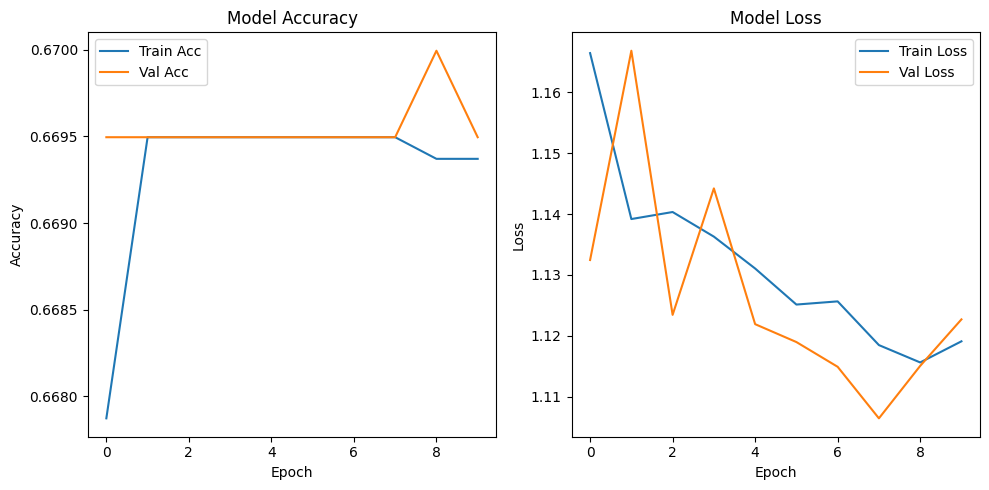

In [6]:
import matplotlib.pyplot as plt

# Plot training & validation accuracy
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


Saving ISIC_0024402.jpg to ISIC_0024402.jpg


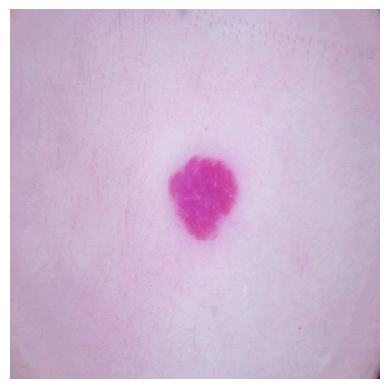

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 199ms/step
Predicted cancer class: bcc


In [10]:
from google.colab import files
from tensorflow.keras.preprocessing import image
import numpy as np

# Upload a file
uploaded = files.upload()
img_path = list(uploaded.keys())[0]

# Preprocess image
img = image.load_img(img_path, target_size=(IMG_SIZE, IMG_SIZE))
plt.imshow(img)
plt.axis('off')
plt.show()

x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = x / 255.0

# Make prediction
pred = model.predict(x)
pred_class = np.argmax(pred, axis=1)[0]

# Map class to label name
inv_lesion_type_dict = {v: k for k, v in lesion_type_dict.items()}
result = inv_lesion_type_dict[pred_class]
print(f"Predicted cancer class: {result}")
